In [1]:

import datetime
from time import sleep
from binance.client import Client
import pandas as pd
import datetime
import time
import numpy as np
import os
import sys
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.stattools import coint

#from crontab import CronTab
from safe_schedule import SafeScheduler
#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#Open location of recorded buy/sell walls
bw_location = '/home/me/Documents/BWA/data/watcher/buywalls/'
sw_location = '/home/me/Documents/BWA/data/watcher/sellwalls/'
save_port = 'home/me/Documents/BWA/data/bw_portfolios'
#Open binance client
client = Client(api_key, secret_key)
#get current time and format to compare with data
current_milli_time = lambda: int(round(time.time() * 1000))
now = str(current_milli_time())

def get_data(sym,prev_k,k,candle_k='5m'):
    prev_k = str(prev_k)
    k = str(k)
    #print("Before",prev_k,k)
    #fix to get data from selected timeframe
    
    #print("After",prev_k,k)
    data = client.get_historical_klines(sym,interval= candle_k,start_str =int(prev_k),end_str = int(k))
    #print(data)
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    #data = data.fillna(method='ffill')
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def normalize(data,column="Close",deci = False):
    if(deci==True):
        norm_close =  data[column].divide(data[column].iloc[0])-1
    else:
        norm_close =  data[column].divide(data[column].iloc[0])
    return norm_close

def get_n_day(df):
    #df = df[:288]
    #print(len(df))
    coins = df['Coin']
    cgroups = df.groupby('Coin')
    top_10 = list(df['Coin'].value_counts().head(10).keys())
    df['1D_freq'] = df.groupby('Coin')['Coin'].transform('count')
    df = df.sort_values(['1D_freq'],ascending=False)
    wall = []
    for i in top_10:
        wall.append(cgroups.get_group(i).iloc[-1].values)
    wall = pd.DataFrame(wall, columns=df.columns.tolist())
    wall = wall.set_index('Coin')
    
    return wall

def create_port(top10):
    portfolio = {}
    for coin in top10.index:
        print(coin)
        startTime = top10.loc[coin]['Date']
        
        #endTime=str(float(startTime)+240000)
        #print(float(endTime)-int(startTime))
        histData = client.get_historical_klines(coin,client.KLINE_INTERVAL_5MINUTE,'3 days ago')
        histData = pd.DataFrame(histData,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
        portfolio[coin] = histData
        #print()
    return portfolio, top10


def to_dt(v,is_milli=True):
    if(is_milli):
        v = datetime.datetime.fromtimestamp(int(v)/1000)
    else:
        v = datetime.datetime.fromtimestamp(int(v))
    return v

def get_freq_sig(loc):
    os.chdir(bw_location)
    files = filter(os.path.isfile,os.listdir(bw_location))
    files =  [int(f) for f in files]
    files = list(files)
    fs_df = pd.DataFrame(files)
    fs_df = fs_df[0].sort_values()
    st,end = to_dt(fs_df.iloc[0]),to_dt(fs_df.iloc[-1])
    bw_freq = []
    f_len = int(len(os.listdir(loc)))
    for c,i in enumerate(os.listdir(loc)):
        try:
            curr = pd.read_csv(loc+i)
        except Exception as e:
            print(i,e)
 
        curr.columns = ['Coin','Close','Profit','Loss','Date']  
        bw_freq.append(curr)
        if(c%5000==0):
            pct = str(int((c/f_len)*100))
            print("{}% of files loaded".format(pct))
    bw_freq = pd.concat(bw_freq)
    bw_freq = bw_freq[['Date','Coin','Close']]
    bw_freq.columns = ['Date','Coin','Close']
    bw_freq = bw_freq.sort_values(['Date'],ascending=False)
    #print(all_w.head(), len(all_w))
    #bw_freq['all_freq'] = bw_freq.groupby('Coin')['Coin'].transform('count')
    #bw_freq = bw_freq.sort_values(['Date'],ascending=False)    
    print(st,end)
    print(to_dt(now), now)
    print(fs_df.head())
    return bw_freq

def clean_fs(fs):
    fs =fs.drop_duplicates()
    fs = fs.sort_values(['Date'],axis=0)
    fs['Date_m'] = fs['Date']/1000
    fs.index = fs['Date_m'].astype('datetime64[s]')

    rolling_f = {}
    f_col = []
    for i in fs.iterrows():
        coin = i[1][1]
        if(coin in rolling_f.keys()):
            rolling_f[coin] += 1
            f_col.append(rolling_f[coin])
        else:
            rolling_f[coin] = 1
            f_col.append(rolling_f[coin])
    print(len(fs),len(f_col))
    fs['rolling_freq'] = f_col
        
    return fs
    #files.sort(key=lambda x: os.path.getmtime(x))    

In [2]:
fs = get_freq_sig(bw_location)

0% of files loaded
22% of files loaded
45% of files loaded
67% of files loaded
90% of files loaded
2018-08-24 00:09:22.289000 2018-12-09 14:49:30.497000
2019-01-08 22:46:25.388000 1547005585388
10068    1535083762289
20903    1535084106238
5125     1535084444624
11294    1535084787792
16224    1535085130313
Name: 0, dtype: int64


In [3]:
fs_c = clean_fs(fs)
print(fs_c.head(10))
print(fs_c.tail(10))

71055 71055
                              Date      Coin     Close        Date_m  \
Date_m                                                                 
2018-08-24 04:09:22  1535083762289    ENGBTC  0.000099  1.535084e+09   
2018-08-24 04:09:22  1535083762289   DASHBTC  0.021344  1.535084e+09   
2018-08-24 04:15:06  1535084106238    ENGBTC  0.000099  1.535084e+09   
2018-08-24 04:15:06  1535084106238  THETABTC  0.000015  1.535084e+09   
2018-08-24 04:20:44  1535084444624    GVTBTC  0.000758  1.535084e+09   
2018-08-24 04:20:44  1535084444624    OAXBTC  0.000024  1.535084e+09   
2018-08-24 04:20:44  1535084444624    ENGBTC  0.000100  1.535084e+09   
2018-08-24 04:20:44  1535084444624   APPCBTC  0.000013  1.535084e+09   
2018-08-24 04:26:27  1535084787792    GVTBTC  0.000754  1.535085e+09   
2018-08-24 04:26:27  1535084787792    ENGBTC  0.000099  1.535085e+09   

                     rolling_freq  
Date_m                             
2018-08-24 04:09:22             1  
2018-08-24 04:0

In [4]:
st,end = fs_c.Date[0],fs_c.Date[-1]
print(to_dt(st))

def interval(intv,st,end):
    int_port = {}
    prev = st
    times = []
    while(prev<end):
        curr = prev+int(86400000*intv)
        n = to_dt(curr).strftime('%Y-%m-%d')
        p = to_dt(prev).strftime('%Y-%m-%d')
        #
        print(p,"  |  ",n)
        prev = curr
        int_port[n] = fs_c.loc[p:n]
        times.append(n)
        
    for t in times:
        port = int_port[t]
        """
        group coins to check if event has correlation with price
        implement as functions
        """
        coins = list(port['Coin'].drop_duplicates())
        cgroups = port.groupby(['Coin'])
        
        coin = cgroups.get_group(coins[2])
        coin = coin[['Close','rolling_freq']].astype(float)

        #try log timedelta
        
        #norm_freq = normalize(coin,column="rolling_freq")

        #print(coin)
        
        break
    return coins,cgroups


    
coins,cgroups = interval(30,st,end)

2018-08-24 00:09:22.289000
2018-08-24   |   2018-09-23
2018-09-23   |   2018-10-23
2018-10-23   |   2018-11-21
2018-11-21   |   2018-12-21


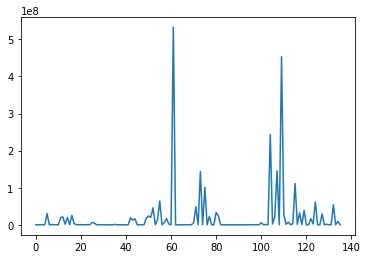

In [5]:
#print(coins)
#utc intervals for ranking event
d = 86400
h = int(d/24)
hhr = int(h/17)
coin = cgroups.get_group(coins[0])
#print(coin.iloc[0])
t_dif = []
for i in range(0,len(coin)-1):
    t1 = coin['Date'].iloc[i]
    t2 = coin['Date'].iloc[i+1]
    td = (t2-t1)
    #if(td) signal logic
    t_dif.append(td)
t_dif.append(0)
t_dif_x = [x for x in range(len(t_dif))]
plt.plot(t_dif_x,t_dif)

plt.show()

## Test daily resampling for signal/event generation

https://alphascientist.com/feature_engineering.html

2018-08-24    |    2018-09-23
ENGBTC
Signal to price movement stats: 

Cointegration: -3.8693780007209764 P-value: 0.010927425155482597


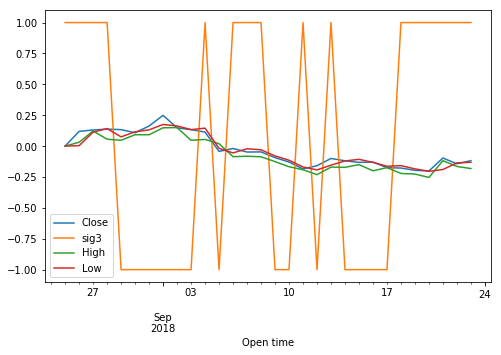

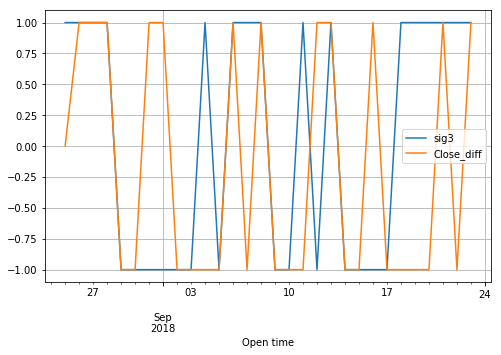

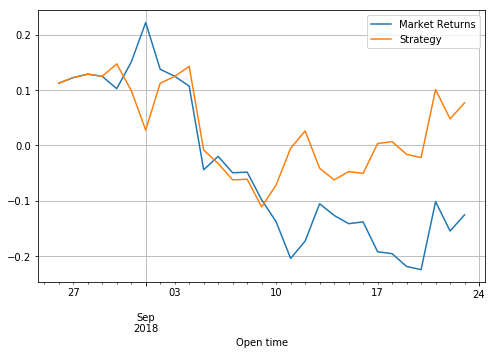

continue y/n: y
2018-08-24    |    2018-09-23
DASHBTC
Signal to price movement stats: 

Cointegration: -4.083376394992296 P-value: 0.0054419007236018715


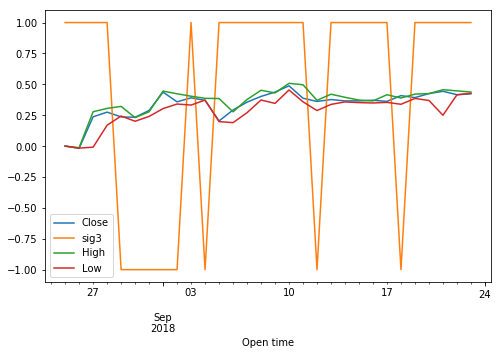

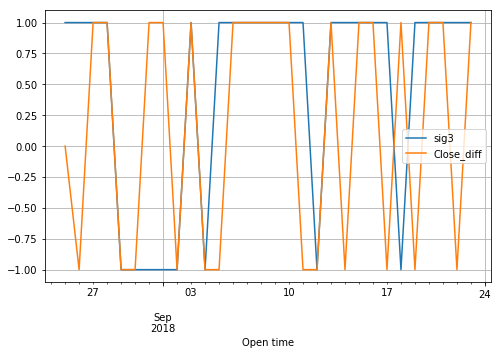

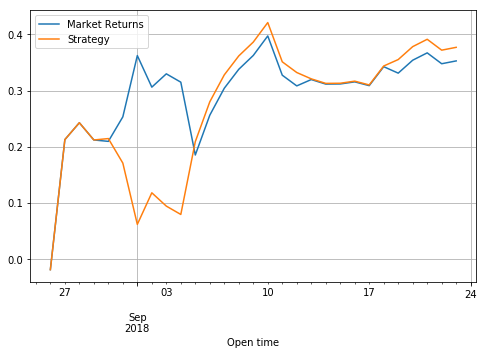

continue y/n: y
2018-08-24    |    2018-09-23
THETABTC
Signal to price movement stats: 

Cointegration: -2.168518203065546 P-value: 0.4406523782734626


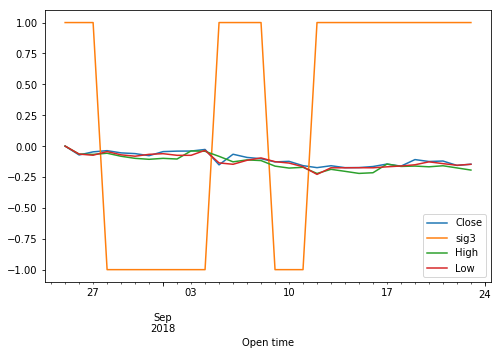

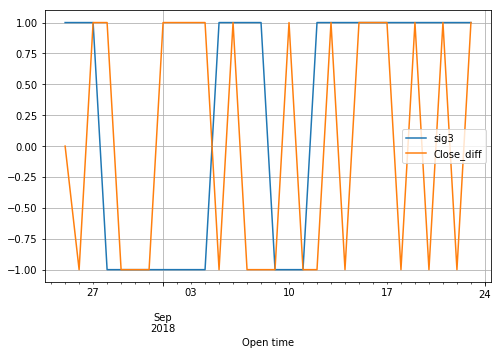

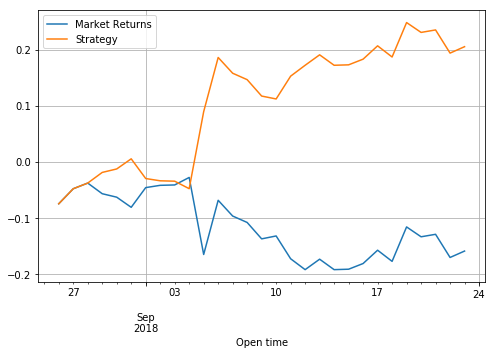

continue y/n: 
2018-08-24    |    2018-09-23
GVTBTC
Signal to price movement stats: 

Cointegration: -2.8435996220383 P-value: 0.15220576905801292


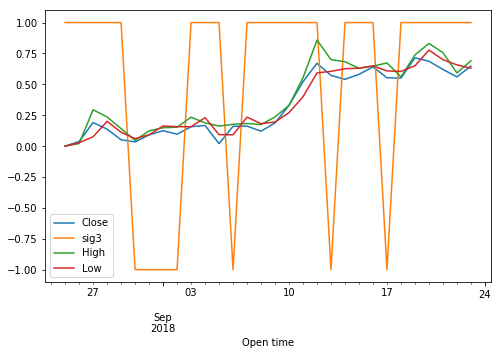

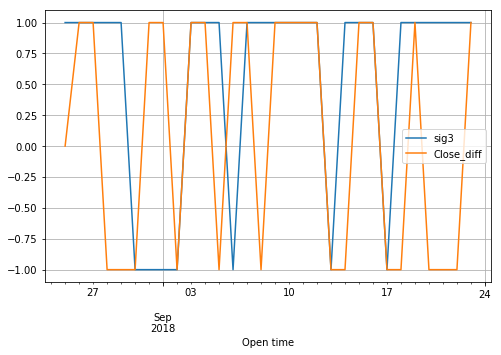

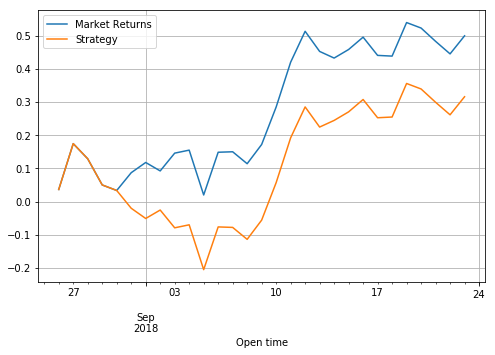

continue y/n: 
2018-08-24    |    2018-09-23
OAXBTC
Signal to price movement stats: 

Cointegration: -2.0795077376319737 P-value: 0.4870822133257889


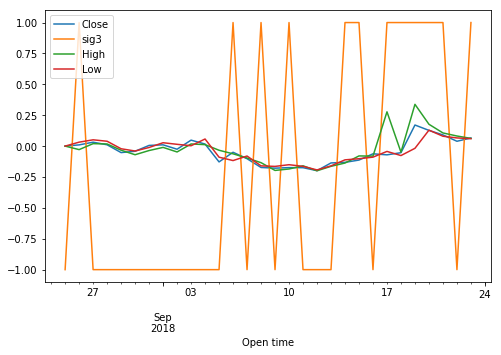

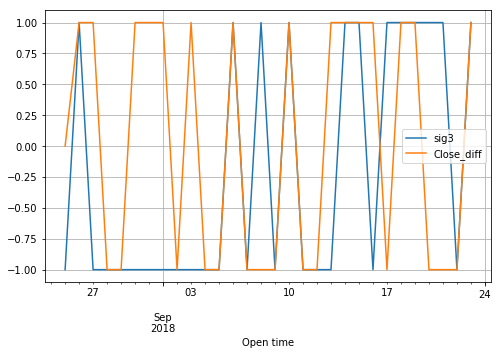

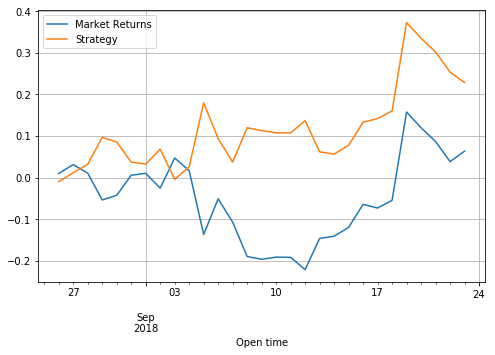

continue y/n: 
2018-08-24    |    2018-09-23
APPCBTC
Signal to price movement stats: 

Cointegration: -3.3625100571194406 P-value: 0.046688420940018883


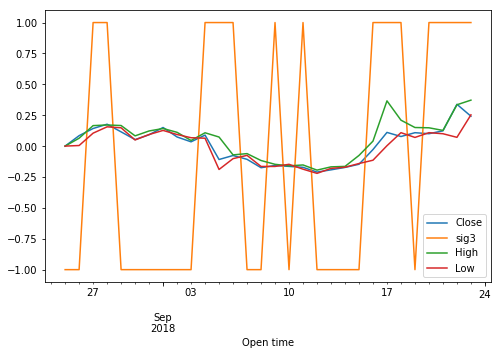

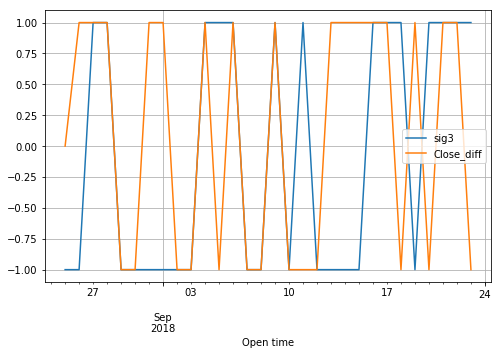

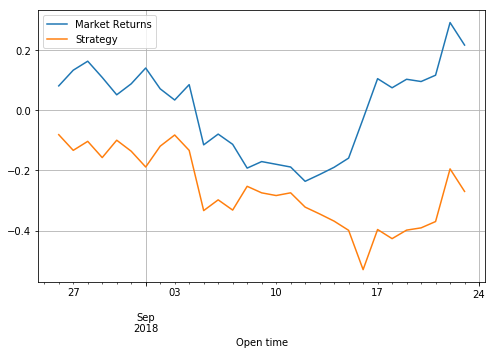

continue y/n: 
2018-08-24    |    2018-09-19
AIONBTC
Signal to price movement stats: 

Cointegration: -3.105730742066897 P-value: 0.08715759158319852


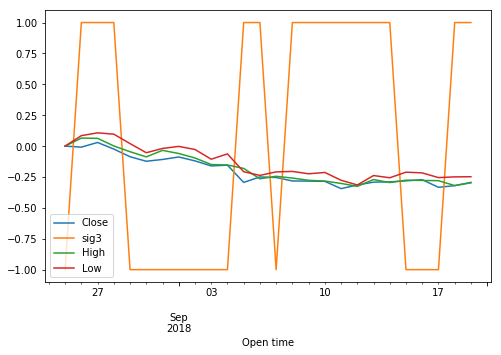

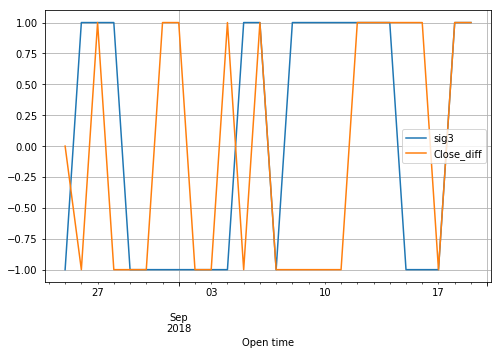

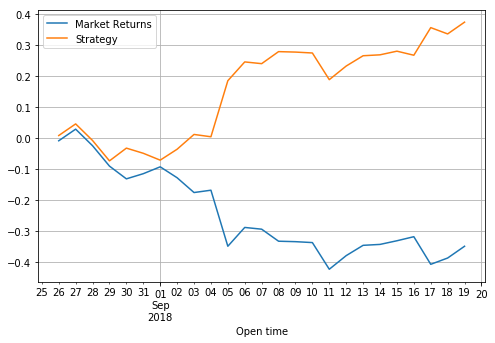

In [ ]:
all_coins = pd.DataFrame()
for sym in coins:
    coin = cgroups.get_group(sym)
    #the secret sauce, extracting value from our data
    #for this example im using the time difference between the signal event occurence to determine enter/exits
    t_dif = []
    for i in range(0,len(coin)-1):
        t1 = coin['Date'].iloc[i]
        t2 = coin['Date'].iloc[i+1]
        td = (t2-t1)
        #if(td) signal logic
        t_dif.append(td)
    t_dif.append(0)
    coin = coin.assign(t_dif = t_dif)
    coin.t_dif = coin.t_dif.shift(1)
    #print(coin.head())
    coin = coin.fillna(method='bfill')
    coin.t_dif = coin.t_dif.pct_change()


    coin = coin[['Close','t_dif']].copy()
    coin.Close = normalize(coin)
    coin.fillna(method='bfill')
    #create daily signals from intrady signal dataset
    daily_coin = coin.resample('D').sum()
    #print(d_coin.head())

    #daily resampled date index
    dates = list(coin.index)
    print(dates[0].strftime('%Y-%m-%d'),"   |   ",dates[-1].strftime('%Y-%m-%d'))
    prev_k,k = int(dates[0].timestamp()*1000), int(dates[-1].timestamp()*1000)

    print(sym)
    #Download historical data
    c_hist = get_data(sym,prev_k,k,candle_k='1d')
    
    #logarithmic volume
    c_hist['log_volume'] = np.log(c_hist.Volume)
    
    #logarithmic volume difference
    c_hist["l_vdiff"] = c_hist['log_volume'].diff()
    #Close diff
    c_hist['Close_diff'] = c_hist['Close'].diff().apply(np.sign)
    
    #extract signal for resampled signal dataframe and create signal column (-1,1) ...maybe (-1,0,1)
    c_hist['bw_sig'] = daily_coin.t_dif
    c_hist['sig3'] = c_hist["bw_sig"].apply(np.sign)
    c_hist['sig3'] = c_hist['sig3'].replace(0,-1)
    c_hist = c_hist.fillna(0) 
    c_hist["daily_returns"] = (c_hist['Close']/c_hist['Open'])-1

    #Visualize trading range and signal
    c_hist2 = c_hist[["Close","sig3"]].copy()
    c_hist2.Close = normalize(c_hist2,deci=True)
    c_hist2["High"] = normalize(c_hist,column="High",deci=True)
    c_hist2["Low"] = normalize(c_hist,column="Low",deci=True)
    c_hist2.plot(figsize=(8,5))
    #plt.savefig("/home/me/Pictures/{}range_signal.png".formate(sym))
    
    c_hist[['sig3','Close_diff']].plot(grid=True,figsize=(8,5))
    result = coint(c_hist['sig3'], c_hist['Close_diff'])
    corr = c_hist[['sig3','Close_diff']].corr()
    print("Signal to price movement stats: \n".format(corr))
    print("Cointegration: {} P-value: {}".format(result[0],result[1]))
    
    



    c_hist['Market Returns'] = np.log(c_hist['Close'] / c_hist['Close'].shift(1))
    c_hist['Strategy'] = c_hist['Market Returns'] * c_hist['sig3'].shift(1)
    c_hist[['Market Returns','Strategy']].cumsum().plot(grid=True,figsize=(8,5))
    plt.show()
    
    cont = input("continue y/n: ")
    if cont == 'n':
        break


#monthly_return = c.resample('M').agg(lambda x: x[-1]/x[1] - 1)

In [ ]:

c_hist

In [ ]:
corr = c_hist.corr()
#print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdYlGn_r')#, mask = (corr >= 0.05))

In [ ]:
c_hist[['sig3','Close_diff']].plot(grid=True,figsize=(8,5))
result = coint(c_hist['sig3'], c_hist['Close_diff'])
corr = c_hist[['sig3','Close_diff']].corr()
print("Signal to price movement stats: \n".format(corr))
print("Correlation: {} Cointegration: {} P-value: {}".format(corr,result[0],result[1]))

c_hist['Market Returns'] = np.log(c_hist['Close'] / c_hist['Close'].shift(1))
c_hist['Strategy'] = c_hist['Market Returns'] * c_hist['sig3'].shift(1)
c_hist[['Market Returns','Strategy']].cumsum().plot(grid=True,figsize=(8,5))